In [14]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [18]:
import tensorflow as tf

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [1104]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/feature_extract_reshaped.npy')
data.shape

data already loaded in parent notebook


(13237, 30, 63)

In [1106]:
import numpy as np

def split_data(data, test_size=0.2, val_size=0.2, random_state=None):
    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [1107]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape)
print(f'test shape', X_test.shape)

train shape (10571, 30, 62)
test shape (2666, 30, 62)


In [1108]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [1109]:
class_weight_dict

{0.0: 0.5362027353177795, 1.0: 7.405555555555556}

In [1110]:
class_weight_dict[1]

7.405555555555556

In [1111]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [27]:
y_train.shape

(1519,)

In [1112]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_split = 0.2)

Epoch 1/300
85/85 [==============================] - 11s 39ms/step - loss: 0.5398 - accuracy: 0.6215 - val_loss: 0.3682 - val_accuracy: 0.9603
Epoch 2/300
85/85 [==============================] - 2s 24ms/step - loss: 0.3998 - accuracy: 0.7752 - val_loss: 0.2813 - val_accuracy: 0.9603
Epoch 3/300
85/85 [==============================] - 2s 23ms/step - loss: 0.3549 - accuracy: 0.8042 - val_loss: 0.2802 - val_accuracy: 0.9603
Epoch 4/300
85/85 [==============================] - 2s 27ms/step - loss: 0.3319 - accuracy: 0.8241 - val_loss: 0.2496 - val_accuracy: 0.9234
Epoch 5/300
85/85 [==============================] - 2s 25ms/step - loss: 0.2979 - accuracy: 0.8388 - val_loss: 0.2741 - val_accuracy: 0.8482
Epoch 6/300
85/85 [==============================] - 2s 25ms/step - loss: 0.2826 - accuracy: 0.8502 - val_loss: 0.3052 - val_accuracy: 0.8071
Epoch 7/300
85/85 [==============================] - 2s 23ms/step - loss: 0.2627 - accuracy: 0.8645 - val_loss: 0.4508 - val_accuracy: 0.7366
Epoch

In [29]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

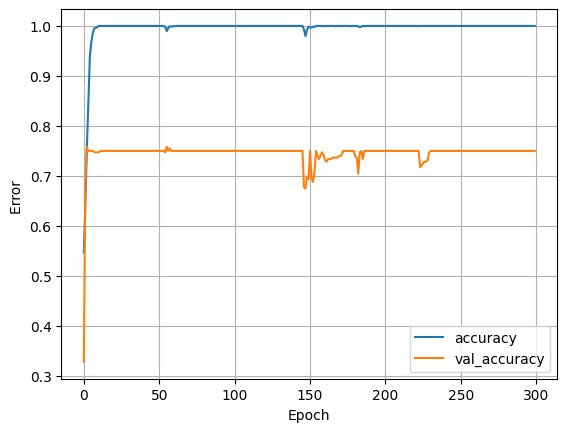

In [30]:
plot_accuracy(history)

In [31]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

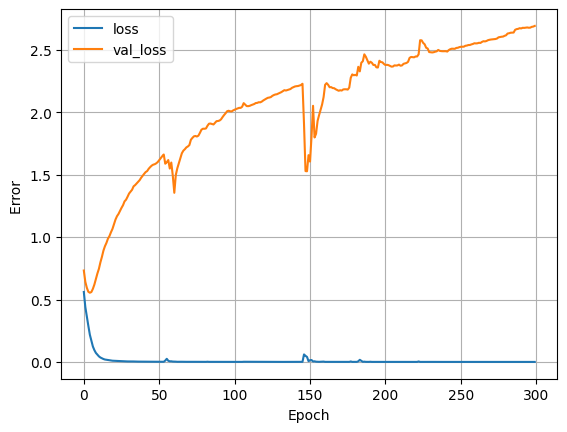

In [32]:
plot_loss(history)

In [33]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[1.6157348155975342, 0.8125]

In [34]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 1.6157 - accuracy: 0.8125 - 39ms/epoch - 2ms/step
Model accuracy: 0.8125


In [35]:
y_pred_train = model.predict(X_train)
y_pred_train

48/48 [==============================] - 0s 2ms/step


array([[1.61546395e-05],
       [1.23438585e-05],
       [1.94262193e-05],
       ...,
       [4.42832279e-05],
       [3.95292300e-05],
       [4.92535946e-05]], dtype=float32)

In [36]:
# plt.figure(figsize=(15,10))  # Adjust the width and height as needed
# plt.plot(y_pred_train[:200])
# plt.plot(y_train[:200])


In [37]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

16/16 [==============================] - 0s 2ms/step


(496, 1)

In [38]:
# plt.figure(figsize=(15,10))  
# plt.plot(y_pred[:200])
# plt.plot(y_test[:200])

In [39]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

 1/16 [>.............................] - ETA: 0s - loss: 2.6089e-05 - accuracy: 1.0000

16/16 [==============================] - 0s 3ms/step - loss: 1.6157 - accuracy: 0.8125
Loss: 1.6157348155975342
Accuracy: 0.8125
Precision: 0.0
Recall: 0.0


/home/weasel/reps/ai-seizure-detectives/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(93.0, 0)

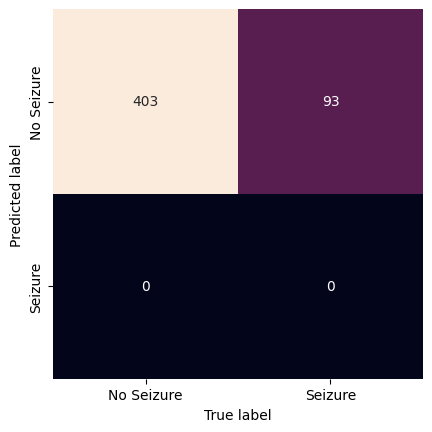

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [41]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90       403
         1.0       0.00      0.00      0.00        93

    accuracy                           0.81       496
   macro avg       0.41      0.50      0.45       496
weighted avg       0.66      0.81      0.73       496



/home/weasel/reps/ai-seizure-detectives/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weasel/reps/ai-seizure-detectives/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weasel/reps/ai-seizure-detectives/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Text(0, 0.5, 'Predictions')

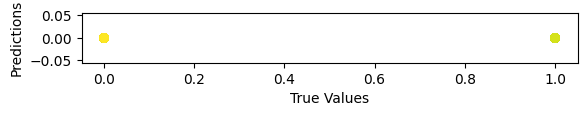

In [42]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [43]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [44]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [45]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [46]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [47]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(72, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
X_train.shape

(1519, 30, 62)

In [49]:
y_train.shape

(1519,)

In [50]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_data=(X_val, y_val))

Epoch 1/300
16/16 [==============================] - 1s 24ms/step - loss: 0.5082 - accuracy: 0.5872 - val_loss: 0.7375 - val_accuracy: 0.4758
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.4051 - accuracy: 0.7307 - val_loss: 0.6737 - val_accuracy: 0.6210
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 0.3465 - accuracy: 0.8308 - val_loss: 0.6449 - val_accuracy: 0.6532
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2934 - accuracy: 0.8920 - val_loss: 0.6057 - val_accuracy: 0.7419
Epoch 5/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2505 - accuracy: 0.9177 - val_loss: 0.5886 - val_accuracy: 0.7419
Epoch 6/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2088 - accuracy: 0.9368 - val_loss: 0.5892 - val_accuracy: 0.7446
Epoch 7/300
16/16 [==============================] - 0s 5ms/step - loss: 0.1751 - accuracy: 0.9487 - val_loss: 0.5711 - val_accuracy: 0.7661
Epoch 8/300


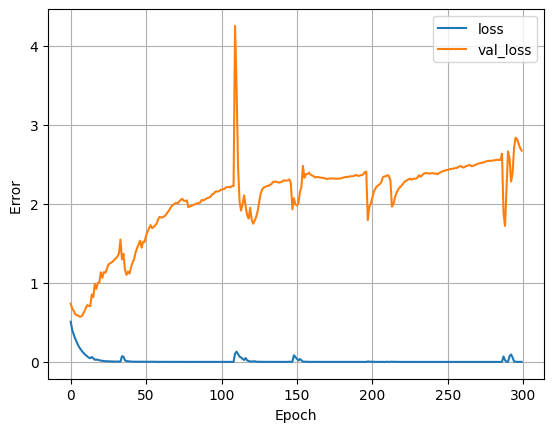

In [51]:
plot_loss(history)

In [52]:
y_pred = model.predict(X_test).flatten()
y_pred

16/16 [==============================] - 0s 2ms/step


array([4.75842608e-05, 1.16255262e-06, 1.42964209e-05, 1.90210085e-05,
       2.73882997e-05, 2.92860886e-06, 1.41938642e-07, 4.22014139e-08,
       4.28024904e-09, 2.68831908e-08, 1.78275769e-07, 1.20379880e-07,
       7.48171078e-05, 1.06487851e-05, 2.56531303e-06, 9.33447595e-08,
       1.05301194e-06, 6.78222659e-06, 3.50655841e-06, 8.14564100e-06,
       1.86041547e-08, 9.51980110e-06, 5.92688230e-05, 1.11429727e-04,
       9.93119029e-05, 3.02377826e-04, 6.70336740e-05, 1.70568048e-04,
       2.07057070e-07, 8.51139612e-06, 5.11444232e-05, 6.21638833e-07,
       4.11830915e-05, 5.29394092e-05, 8.04618758e-05, 6.71831585e-05,
       1.47229322e-04, 3.14955469e-05, 1.95127795e-05, 1.21345489e-04,
       1.43474768e-04, 1.09911780e-04, 1.18896431e-04, 1.87109472e-04,
       3.57833022e-04, 2.25989643e-04, 2.32247970e-04, 7.49437168e-05,
       1.11043410e-04, 2.76380561e-05, 2.38498415e-05, 6.33916570e-05,
       1.39067895e-04, 1.26634113e-04, 1.27313833e-04, 9.22537438e-05,
      

In [53]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 1.7415 - accuracy: 0.8286 - 29ms/epoch - 2ms/step
Model accuracy: 0.8286290168762207


In [54]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

16/16 [==============================] - 0s 1ms/step - loss: 1.7415 - accuracy: 0.8286
Loss: 1.7415165901184082
Accuracy: 0.8286290168762207
Precision: 1.0
Recall: 0.08602150537634409


(93.0, 8)

Text(0, 0.5, 'Predictions')

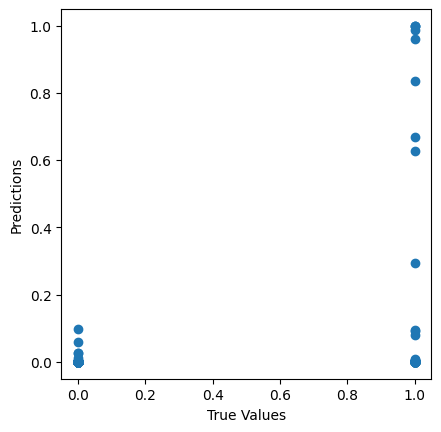

In [55]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')